In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
data_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Data/'
output_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Data/netcdf/'
torch_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Michael_pytorch/'

Load inflow data and climate model simulations of precipitation and temperature:

In [3]:
df_cmip6 = pd.read_csv(data_path+'Clean/cmip6_all.csv', encoding ='ISO-8859-1')
df_inflow = pd.read_csv(data_path+'Clean/inflow.csv', encoding ='ISO-8859-1')

/tmp/ipykernel_2029368/3098425882.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cmip6 = pd.read_csv(data_path+'Clean/cmip6_all.csv', encoding ='ISO-8859-1')


Load inflow mean and std (needed for reversing the standardization):

In [4]:
inflow_mean = pd.read_csv(torch_path+'parameters/inflow_mean.csv', index_col=0).rename(columns=int)
inflow_std = pd.read_csv(torch_path+'parameters/inflow_std.csv', index_col=0).rename(columns=int)

In [5]:
months = inflow_mean.columns
catchment_names = inflow_mean.index
nbs = len(catchment_names)

years_train = [*range(1981,2021)]
years_all = [*range(1960,2101)]
nyrs = len(years_all)

Load fitted regression coefficients:

In [6]:
reg_coef_prcp_ccr = pd.read_csv(torch_path+'parameters/coef_ann_prcp_ccr.csv', index_col=0).rename(columns=int)
reg_coef_prcp_lg1 = pd.read_csv(torch_path+'parameters/coef_ann_prcp_lg1.csv', index_col=0).rename(columns=int)
reg_coef_prcp_lg234 = pd.read_csv(torch_path+'parameters/coef_ann_prcp_lg234.csv', index_col=0).rename(columns=int)
reg_coef_t2m = pd.read_csv(torch_path+'parameters/coef_ann_temp_ccr.csv', index_col=0).rename(columns=int)

Next, we load a list of climate models to make sure we use the same models that were used in an earlier stage of the project. This is not relevant for other users who want to reproduce our methodology with a different data set:

In [7]:
data_load = xr.open_dataset(output_path+'projections_climate_regression_cmip6.nc', engine='netcdf4')
model_names_cmip6 = data_load.model.values
data_load.close()
ncm6 = len(model_names_cmip6)

## 1. Calculate the CMIP6 based inflow projections:

In [8]:
inflow_projection_cmip6 = np.full((ncm6,nbs,12,nyrs), np.nan, dtype=np.float32)

for imd in range(ncm6):
    model = model_names_cmip6[imd]
    print('Calculating projections for '+model)
    for ibs in range(nbs):
        id_catchment = catchment_names[ibs]
        proj_catchment = df_cmip6.loc[(df_cmip6['model']==model) & (df_cmip6['catchid']==id_catchment)]
        proj_catchment.index = pd.to_datetime(proj_catchment['year'].astype(str)+'-'+proj_catchment['month'].astype(str)+'-1')
        proj_catchment.insert(7, 'precip_lg1', proj_catchment['precip'].rolling(2).sum().shift(1))
        proj_catchment.insert(8, 'precip_lg234', proj_catchment['precip'].rolling(3).sum().shift(3))
        for imt in range(12):
            month = months[imt]
            proj_predictors = proj_catchment.loc[proj_catchment['month']==int(month), ['year','precip','precip_lg1','precip_lg234','temp']]
            proj_predictors.set_index('year', inplace=True)
            if proj_predictors.size == 0:
                continue
            reg_coef = pd.Series([reg_coef_prcp_ccr.loc[id_catchment,month],
                                  reg_coef_prcp_lg1.loc[id_catchment,month],
                                  reg_coef_prcp_lg234.loc[id_catchment,month],
                                  reg_coef_t2m.loc[id_catchment,month]],
                                  index=['precip','precip_lg1','precip_lg234','temp'])
            if np.isnan(reg_coef).any():
                print('Skipping '+id_catchment+' for month = '+str(month))
                continue
            proj_train = proj_predictors.loc[proj_predictors.index.isin(years_train), ['precip','precip_lg1','precip_lg234','temp']]
            proj_all = proj_predictors.loc[proj_predictors.index.isin(years_all), ['precip','precip_lg1','precip_lg234','temp']]
            proj_all_stdz = (proj_all-proj_train.mean(0))/proj_train.std(0)
            inflow_projection_cmip6[imd,ibs,imt,:] = inflow_mean.loc[id_catchment,month] + inflow_std.loc[id_catchment,month] * (proj_all_stdz @ reg_coef)

Calculating projections for ACCESS-CM2
Skipping catch131 for month = 1
Skipping catch131 for month = 2
Skipping catch131 for month = 3
Skipping catch131 for month = 4
Skipping catch131 for month = 12
Skipping catch201 for month = 7
Skipping catch201 for month = 8
Skipping catch202 for month = 5
Skipping catch202 for month = 6
Skipping catch202 for month = 7
Skipping catch202 for month = 8
Skipping catch202 for month = 9
Skipping catch202 for month = 10
Skipping catch202 for month = 11
Skipping catch296 for month = 7
Skipping catch296 for month = 8
Skipping catch296 for month = 9
Skipping catch302 for month = 1
Skipping catch302 for month = 6
Skipping catch302 for month = 7
Skipping catch302 for month = 8
Skipping catch302 for month = 9
Skipping catch302 for month = 10
Skipping catch302 for month = 11
Skipping catch302 for month = 12
Calculating projections for BCC-CSM2-MR
Skipping catch131 for month = 1
Skipping catch131 for month = 2
Skipping catch131 for month = 3
Skipping catch131 f

For some plots we may also want to look at the 'fitted values', i.e. inflow predicted by the regression model based on the ERA5/CHIRPS data it was fitted to. Those are calculated next:

In [9]:
nc = xr.open_dataset(f'{data_path}inflow_temp_precip_data.nc', engine='netcdf4')
catchment_names = list(nc.catchid.values)
months = list(nc.month.values)
years_fitted = list(nc.year.values)
predictors = nc.predictors.values
nc.close()

nbs, nmts, nyrs, nprs = predictors.shape

predictors_mean = np.nanmean(predictors, axis=2)
predictors_std = np.nanstd(predictors, axis=2)

inflow_fitted = np.full((nbs,nmts,nyrs), np.nan, dtype=np.float32)

for ibs in range(nbs):
    id_catchment = catchment_names[ibs]
    for imt in range(12):
        month = months[imt]
        X = np.nan_to_num((predictors[ibs,imt,:,:] - predictors_mean[ibs,imt,None,:]) / predictors_std[ibs,imt,None,:], 0.0)
        beta = np.array([reg_coef_prcp_ccr.loc[id_catchment,month], reg_coef_prcp_lg1.loc[id_catchment,month], reg_coef_prcp_lg234.loc[id_catchment,month], reg_coef_t2m.loc[id_catchment,month]])
        if np.isnan(beta).any():
            print('Skipping '+id_catchment+' for month = '+str(month))
            continue
        inflow_fitted[ibs,imt,:] = inflow_mean.loc[id_catchment,month] + inflow_std.loc[id_catchment,month] * np.dot(X,beta)


Skipping catch131 for month = 1
Skipping catch131 for month = 2
Skipping catch131 for month = 3
Skipping catch131 for month = 4
Skipping catch131 for month = 12
Skipping catch201 for month = 7
Skipping catch201 for month = 8
Skipping catch202 for month = 5
Skipping catch202 for month = 6
Skipping catch202 for month = 7
Skipping catch202 for month = 8
Skipping catch202 for month = 9
Skipping catch202 for month = 10
Skipping catch202 for month = 11
Skipping catch296 for month = 7
Skipping catch296 for month = 8
Skipping catch296 for month = 9
Skipping catch302 for month = 1
Skipping catch302 for month = 6
Skipping catch302 for month = 7
Skipping catch302 for month = 8
Skipping catch302 for month = 9
Skipping catch302 for month = 10
Skipping catch302 for month = 11
Skipping catch302 for month = 12


Load catchment information (names, coordinates, etc.):

##  2. Plot ensemble of projections for selected months and catchments

In [10]:
df_catchment_info = pd.read_csv(data_path+'Clean/catchinfo.csv', encoding ='ISO-8859-1')
df_catchment_info = df_catchment_info.set_index('catchid')
df_catchment_info = df_catchment_info.reindex(catchment_names)
catchment_plt = df_catchment_info.index

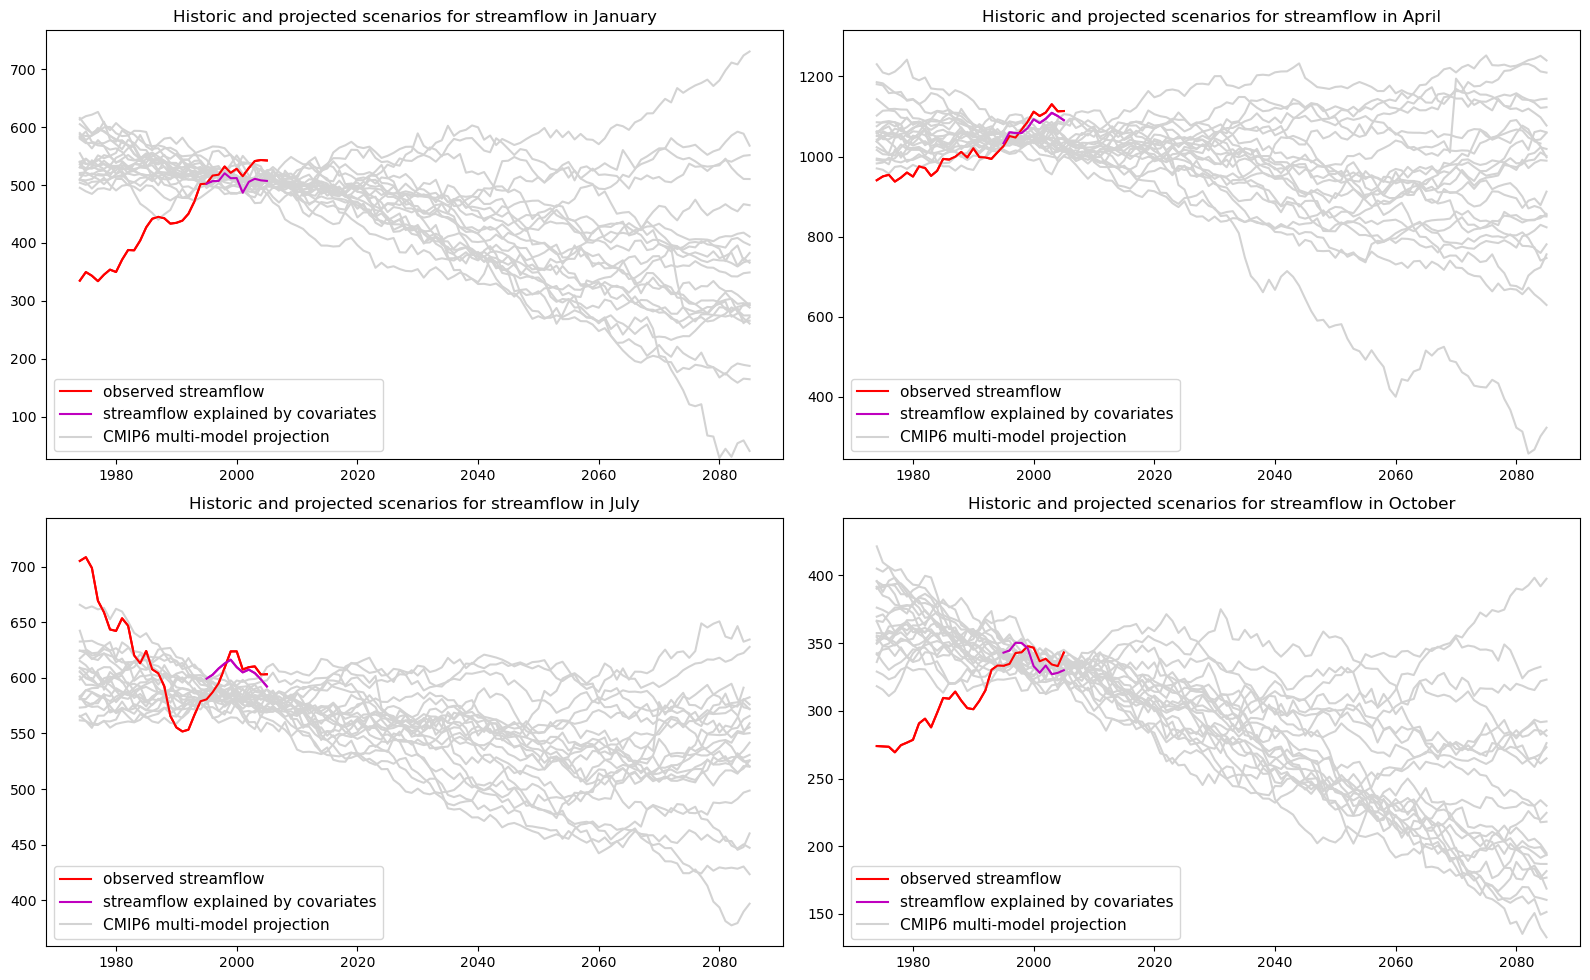

In [11]:
id_catchment = 'catch269'
ibs = np.where(np.array(catchment_names)==id_catchment)[0][0]

month_name = ['January','February','March','April','May','June','July','August','September','October','November','December']

fig = plt.figure(figsize=(16,10))
for i in range(4):
    month = [1,4,7,10][i]
    imt = month-1
    df_inflow_cmip6_catchment = pd.DataFrame(data=inflow_projection_cmip6[:,ibs,imt,:].T, index=years_all)
    df_inflow_catchment = df_inflow.loc[(df_inflow['month']==month) & (df_inflow['catchid']==catchment_names[ibs]), ['year','inflow']].set_index('year')
    df_cmip6_30y_avg = df_inflow_cmip6_catchment.rolling(30, center=True).mean().shift(-1)
    df_cmip6_30y_avg.insert(0, 'obs', df_inflow_catchment.rolling(30, center=True).mean().shift(-1).reindex(df_cmip6_30y_avg.index))
    df_cmip6_30y_avg.insert(1, 'fitted', pd.Series(inflow_fitted[ibs,imt,:], index=years_fitted).rolling(30, center=True).mean().shift(-1))
    vmin = 0.95 * df_cmip6_30y_avg.min().min()
    vmax = 1.05 * df_cmip6_30y_avg.max().max()
    ax = fig.add_subplot(221+i)
    df_cmip6_30y_avg.plot(ax=ax, color=['r','m']+['lightgrey']*df_inflow_cmip6_catchment.columns.size, ylim=(vmin,vmax))
    df_cmip6_30y_avg[['obs','fitted']].plot(ax=ax, color=['r','m'], ylim=(vmin,vmax))
    ax.legend(['observed streamflow','streamflow explained by covariates','CMIP6 multi-model projection'], loc='lower left', fontsize=11)
    ax.set_title(f'Historic and projected scenarios for streamflow in {month_name[imt]}', fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.99])

##  3. Plot maps of projected streamflow changes between the reference period and the 30-year period around a given year

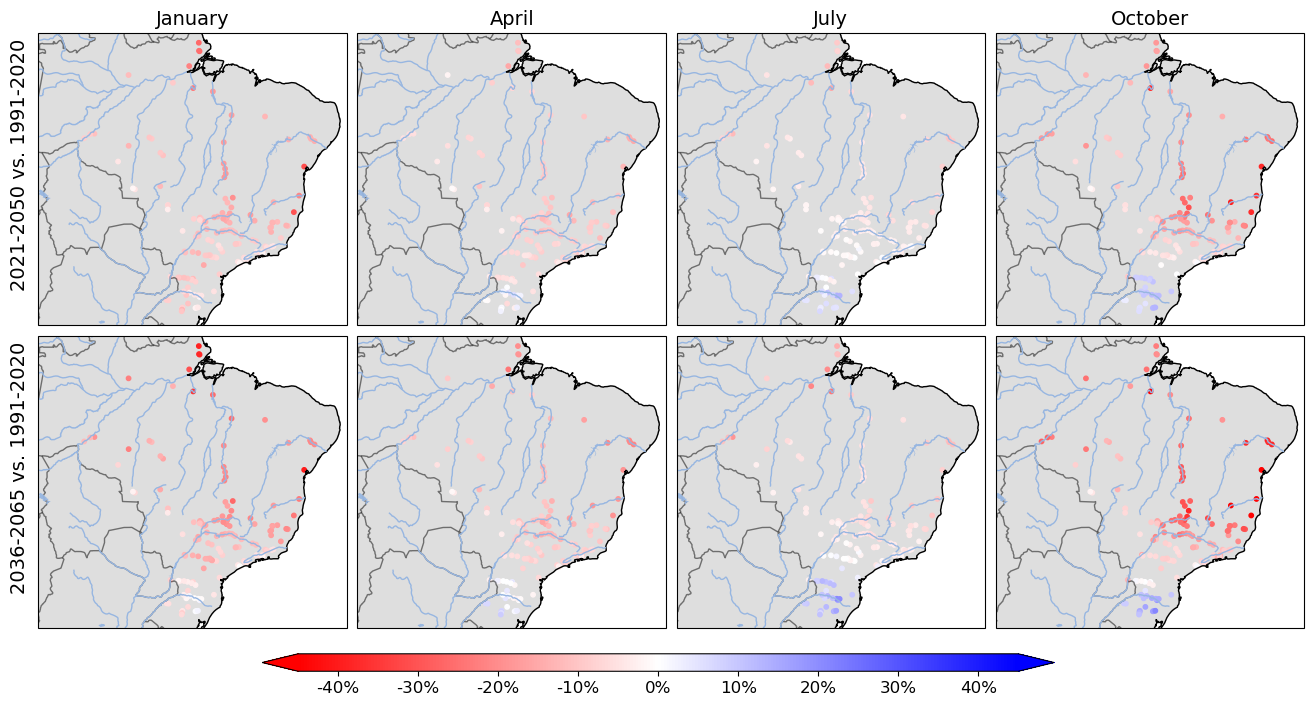

In [12]:
lon_bounds = [-70., -34.]    # Brazil
lat_bounds = [-31.,  3.]    # Brazil

year_plt = [2035,2050]
iyr_ref = np.where(pd.Index(years_all)==2005)[0][0]

fig, axs = plt.subplots(nrows=2, ncols=4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(13.2,7))
for i in range(2):
    iyr = np.where(pd.Index(years_all)==year_plt[i])[0][0]
    for j in range(4):
        imt = [1,4,7,10][j] -1
        inflow_reference = pd.DataFrame(data=np.mean(inflow_projection_cmip6[:,:,imt,(iyr_ref-14):(iyr_ref+16)], axis=2).T, index=df_catchment_info.index, columns=model_names_cmip6)
        inflow_projection = pd.DataFrame(data=np.mean(inflow_projection_cmip6[:,:,imt,(iyr-14):(iyr+16)], axis=2).T, index=df_catchment_info.index, columns=model_names_cmip6)
        inflow_change = inflow_projection.div(inflow_reference, axis=0)
        axs[i,j].set_extent(lon_bounds+lat_bounds, crs=ccrs.PlateCarree())
        axs[i,j].add_feature(cfeature.LAND, color="lightgrey", alpha=0.75)
        axs[i,j].add_feature(cfeature.COASTLINE)
        axs[i,j].add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
        axs[i,j].add_feature(cfeature.LAKES, alpha=0.95)
        axs[i,j].add_feature(cfeature.RIVERS)
        if i == 0:
            axs[i,j].set_title(['January','April','July','October'][j], fontsize=14)
        cscatter = axs[i,j].scatter(x=df_catchment_info['Lon'], y=df_catchment_info['Lat'], c=100*(inflow_change.median(1)-1.), cmap='bwr_r', s=10, transform=ccrs.PlateCarree(), vmin=-45, vmax=45)

axs[0,0].text(-0.03, 0.55, f'{year_plt[0]-14}-{year_plt[0]+15} vs. 1991-2020', va='bottom', ha='center',  rotation='vertical', rotation_mode='anchor', transform=axs[0,0].transAxes, fontsize=14)
axs[1,0].text(-0.03, 0.55, f'{year_plt[1]-14}-{year_plt[1]+15} vs. 1991-2020', va='bottom', ha='center',  rotation='vertical', rotation_mode='anchor', transform=axs[1,0].transAxes, fontsize=14)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.03, right=0.99, wspace=0.03, hspace=0.04)
cbar_ax = fig.add_axes([0.2, 0.038, 0.6, 0.025])
cbar = plt.colorbar(cscatter, cax=cbar_ax, orientation='horizontal', extend='both')
#cbar.set_label('%')
cbar.set_ticks([*range(-40,41,10)])
cbar.set_ticklabels([f'{pct}%' for pct in range(-40,41,10)])
cbar.ax.tick_params(labelsize=12)
fig.canvas.draw()